# Embedding Networks

## Text tokenization and padding

### Tokenization

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer

NB_WORDS = 40000  # Parameter indicating the number of words we'll put in the dictionary
MAX_LEN = 20  # Maximum number of words in a sequence
FILTER_STRING='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n'

sentences=["John is going to the bus stop",
           "The technician is repairing the F512"]

tokenizer = Tokenizer(num_words=NB_WORDS,filters=FILTER_STRING,lower=True, split=" ",oov_token="<OOV>")
tokenizer.fit_on_texts(sentences) #fits the sentences, creating the dictionary
print("Word index:",tokenizer.word_index)

t=tokenizer.texts_to_sequences(sentences)
print("Sequences:",t)

print("Reconstructed sentences",tokenizer.sequences_to_texts(t))

Word index: {'<OOV>': 1, 'the': 2, 'is': 3, 'john': 4, 'going': 5, 'to': 6, 'bus': 7, 'stop': 8, 'technician': 9, 'repairing': 10, 'f512': 11}
Sequences: [[4, 3, 5, 6, 2, 7, 8], [2, 9, 3, 10, 2, 11]]
Reconstructed sentences ['john is going to the bus stop', 'the technician is repairing the f512']


### Sentence padding

In [35]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sentences = pad_sequences(t, maxlen=MAX_LEN,padding='post', truncating='post')
print(padded_sentences)

[[ 4  3  5  6  2  7  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  9  3 10  2 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


## Word Embedding in Keras

### Importing the dataset

In [36]:
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks


def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

dataset=pd.read_csv("IMDB_Dataset.csv")

### Setting model hyperparameters

In [37]:
NB_WORDS = 30000  # Parameter indicating the number of words we'll put in the dictionary
NB_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 50  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 100  # Maximum number of words in a sequence
FILTER_STRING='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n'
EMBEDDING_SIZE=100 # Size of the word embedding
PATIENCE=5 # Patience level
DROP_RATE=0.4 # Dropout rate

### Creating training, validation, and test set

In [38]:
dataset['review']=dataset['review'].map(strip_html)

X_trainAll, X_test, y_trainAll, y_test = train_test_split(dataset['review'], dataset['sentiment'],
                                                    test_size=0.10, random_state=10)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainAll, y_trainAll,
                                                          test_size=0.20, random_state=10)

/var/folders/pg/ykf3591d58z1z4kgmjn1k1040000gn/T/ipykernel_12563/3180392400.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### Creating sequences and encoding labels

In [39]:
tokenizer = Tokenizer(num_words=NB_WORDS,filters=FILTER_STRING,
                      lower=True, split=" ",oov_token="<OOV>")

tokenizer.fit_on_texts(X_train) #fits the sentences, creating the dictionary
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_valid_seq_trunc = pad_sequences(X_valid_seq, maxlen=MAX_LEN, padding='post')
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

le = LabelEncoder()
y_train_le=le.fit_transform(y_train)
y_valid_le=le.transform(y_valid)
y_test_le=le.transform(y_test)



### Creating the model

In [41]:
voc_len=len(tokenizer.word_index)

model = models.Sequential()
model.add(layers.Input(shape=(MAX_LEN,)))
model.add(layers.Embedding(voc_len,EMBEDDING_SIZE))
model.add(layers.Flatten())
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 100)       │    10,870,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,167,569 (46.42 MB)

 Trainable params: 12,167,569 (46.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [42]:
checkpoint_cb = callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)


early_stopping_cb = callbacks.EarlyStopping(patience=PATIENCE,
                                                  restore_best_weights=True)
history = model.fit(X_train_seq_trunc, y_train_le, epochs=NB_EPOCHS,
                    validation_data=(X_valid_seq_trunc, y_valid_le),
                    callbacks=[checkpoint_cb, early_stopping_cb],batch_size=BATCH_SIZE)

model = models.load_model("my_keras_model.keras") # rollback to best model

Epoch 1/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 98s 134ms/step - accuracy: 0.6863 - loss: 0.5472 - val_accuracy: 0.8513 - val_loss: 0.3322
Epoch 2/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 89s 123ms/step - accuracy: 0.9453 - loss: 0.1533 - val_accuracy: 0.8420 - val_loss: 0.3878
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 89s 124ms/step - accuracy: 0.9846 - loss: 0.0446 - val_accuracy: 0.8391 - val_loss: 0.5762
Epoch 4/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 88s 122ms/step - accuracy: 0.9891 - loss: 0.0277 - val_accuracy: 0.8399 - val_loss: 0.7117
Epoch 5/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 87s 121ms/step - accuracy: 0.9932 - loss: 0.0207 - val_accuracy: 0.8439 - val_loss: 0.7046
Epoch 6/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 90s 125ms/step - accuracy: 0.9934 - loss: 0.0170 - val_accuracy: 0.8377 - val_loss: 0.7693


### Evaluating the model

Training Accuracy: 0.9501
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8623 - loss: 0.3313
Testing Accuracy:  0.8634


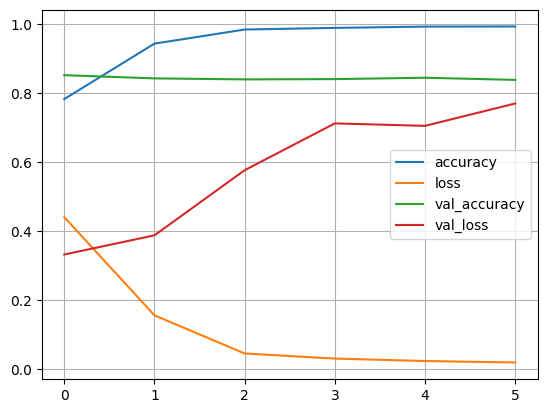

In [43]:
loss, accuracy = model.evaluate(X_train_seq_trunc, y_train_le, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test_seq_trunc, y_test_le, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

## Sentiment analysis with multiple levels

### Reading the dataset

In [44]:
dataset=pd.read_csv("Reddit_clean.csv")
print(dataset.head())
dataset['clean_comment']=dataset['clean_comment'].map(str)

                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1


In [45]:
NB_WORDS = 30000  # Parameter indicating the number of words we'll put in the dictionary
NB_EPOCHS = 5  # Number of epochs we usually start to train with
BATCH_SIZE = 50  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 100  # Maximum number of words in a sequence
FILTER_STRING='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n'
EMBEDDING_SIZE=100 # Size of the word embedding
PATIENCE=3 # Patience level
DROP_RATE=0.4 # Dropout rate

### Training test, validation, and sentence processing

In [46]:
X_trainAll, X_test, y_trainAll, y_test = train_test_split(dataset['clean_comment'], dataset['category'],
                                                    test_size=0.10, random_state=10)

X_train, X_valid, y_train, y_valid = train_test_split(X_trainAll, y_trainAll,
                                                          test_size=0.20, random_state=10)


tokenizer = Tokenizer(num_words=NB_WORDS,filters=FILTER_STRING,
                      lower=True, split=" ",oov_token="<OOV>")

tokenizer.fit_on_texts(X_train) #fits the sentences, creating the dictionary
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_valid_seq_trunc = pad_sequences(X_valid_seq, maxlen=MAX_LEN, padding='post')
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

### One-hot encoding of labels

In [47]:
from sklearn.preprocessing import OneHotEncoder

oh=OneHotEncoder()
y_train_oh=oh.fit_transform([[x] for x in y_train]).toarray()
y_valid_oh=oh.transform([[x] for x in y_valid]).toarray()
y_test_oh=oh.transform([[x] for x in y_test]).toarray()

print(y_train_oh)

[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


### Creating the model

In [48]:
oc_len=len(tokenizer.word_index)

model = models.Sequential()
model.add(layers.Input(shape=(MAX_LEN,)))
model.add(layers.Embedding(voc_len+1,EMBEDDING_SIZE))
model.add(layers.Flatten())
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 100)       │    10,870,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,167,927 (46.42 MB)

 Trainable params: 12,167,927 (46.42 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [49]:
checkpoint_cb = callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)


early_stopping_cb = callbacks.EarlyStopping(patience=PATIENCE,
                                                  restore_best_weights=True)
history = model.fit(X_train_seq_trunc, y_train_oh, epochs=NB_EPOCHS,
                    validation_data=(X_valid_seq_trunc, y_valid_oh),
                    callbacks=[checkpoint_cb, early_stopping_cb],batch_size=BATCH_SIZE)

Epoch 1/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step - accuracy: 0.5851 - loss: 0.8922 - val_accuracy: 0.7534 - val_loss: 0.5856
Epoch 2/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 65s 122ms/step - accuracy: 0.8231 - loss: 0.4354 - val_accuracy: 0.8463 - val_loss: 0.4139
Epoch 3/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 63s 119ms/step - accuracy: 0.9517 - loss: 0.1536 - val_accuracy: 0.8496 - val_loss: 0.4794
Epoch 4/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - accuracy: 0.9779 - loss: 0.0760 - val_accuracy: 0.8489 - val_loss: 0.5359
Epoch 5/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 63s 120ms/step - accuracy: 0.9850 - loss: 0.0512 - val_accuracy: 0.8582 - val_loss: 0.5956


### Model evaluation

Training Accuracy: 0.9636
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8452 - loss: 0.4062
Testing Accuracy:  0.8397


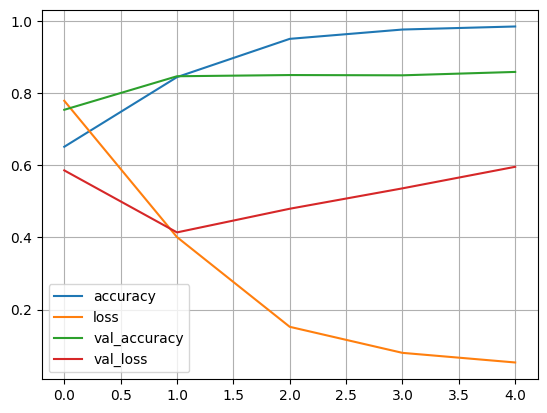

In [50]:
model = models.load_model("my_keras_model.keras") # rollback to best model

loss, accuracy = model.evaluate(X_train_seq_trunc, y_train_oh, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test_seq_trunc, y_test_oh, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

In [51]:
#Prediction metrics
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test_seq_trunc, verbose=1)
print(y_pred)

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[[8.5046273e-03 5.7891608e-05 9.9143744e-01]
 [1.2042620e-02 9.8499292e-01 2.9644147e-03]
 [2.8334672e-03 3.8067878e-07 9.9716610e-01]
 ...
 [1.0425220e-01 7.6764911e-01 1.2809874e-01]
 [1.1632484e-02 9.8017019e-01 8.1974110e-03]
 [3.0644494e-01 1.3540154e-02 6.8001491e-01]]


Training Accuracy: 0.9636
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8452 - loss: 0.4062
Testing Accuracy:  0.8397


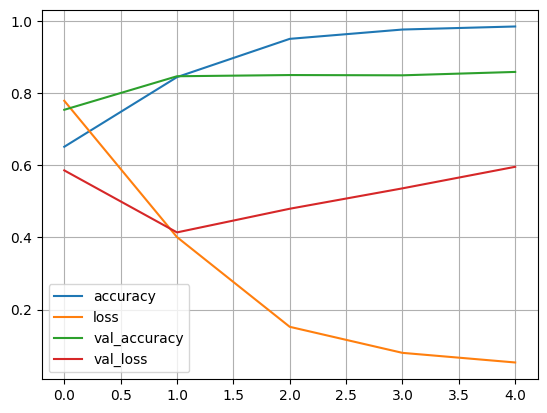

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion matrix:  col_0   -1     0     1
row_0                 
-1     501    84   253
 0      44  1145    63
 1      94    50  1435
              precision    recall  f1-score   support

          -1       0.78      0.60      0.68       838
           0       0.90      0.91      0.90      1252
           1       0.82      0.91      0.86      1579

    accuracy                           0.84      3669
   macro avg       0.83      0.81      0.82      3669
weighted avg       0.84      0.84      0.83      3669



In [52]:
model = models.load_model("my_keras_model.keras") # rollback to best model

loss, accuracy = model.evaluate(X_train_seq_trunc, y_train_oh, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test_seq_trunc, y_test_oh, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

#Prediction metrics
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test_seq_trunc, verbose=1)

y_pred_cat=np.argmax(y_pred,axis=1)-1
y_test_cat=np.argmax(y_test_oh,axis=1)-1
print("Confusion matrix: ",pd.crosstab(y_test_cat,y_pred_cat))

print(classification_report(y_test_cat,y_pred_cat))

## Using a pre-trained embedding

### Loading the embedding

In [53]:
import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [54]:
EMBEDDING_SIZE=glove_vectors.vector_size
vocab_size=len(glove_vectors.key_to_index)

### Creating the vectors for the vocabulary words

In [55]:
embedding_matrix = np.zeros((voc_len, EMBEDDING_SIZE))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_vector = glove_vectors[word]
        embedding_matrix[i] = embedding_vector

### Creating the model

In [56]:
from tensorflow.keras import initializers
model = models.Sequential()
model.add(layers.Input(shape=(MAX_LEN,)))
model.add(layers.Embedding(
    voc_len,
    EMBEDDING_SIZE,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=False))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 100)       │    10,870,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,123,411 (61.51 MB)

 Trainable params: 5,252,611 (20.04 MB)

 Non-trainable params: 10,870,800 (41.47 MB)

### Model Training

In [57]:
checkpoint_cb = callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)


early_stopping_cb = callbacks.EarlyStopping(patience=PATIENCE,
                                                  restore_best_weights=True)
history = model.fit(X_train_seq_trunc, y_train_oh, epochs=NB_EPOCHS,
                    validation_data=(X_valid_seq_trunc, y_valid_oh),
                    callbacks=[checkpoint_cb, early_stopping_cb],batch_size=BATCH_SIZE)

Epoch 1/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 59s 107ms/step - accuracy: 0.5636 - loss: 0.5702 - val_accuracy: 0.6261 - val_loss: 0.5014
Epoch 2/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 60s 113ms/step - accuracy: 0.6260 - loss: 0.4913 - val_accuracy: 0.6367 - val_loss: 0.4826
Epoch 3/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 62s 118ms/step - accuracy: 0.6583 - loss: 0.4628 - val_accuracy: 0.6452 - val_loss: 0.4771
Epoch 4/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 64s 120ms/step - accuracy: 0.6771 - loss: 0.4385 - val_accuracy: 0.6506 - val_loss: 0.4742
Epoch 5/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 53s 100ms/step - accuracy: 0.7017 - loss: 0.4101 - val_accuracy: 0.6438 - val_loss: 0.4735


### Results

Training Accuracy: 0.8109
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6471 - loss: 0.4752
Testing Accuracy:  0.6470


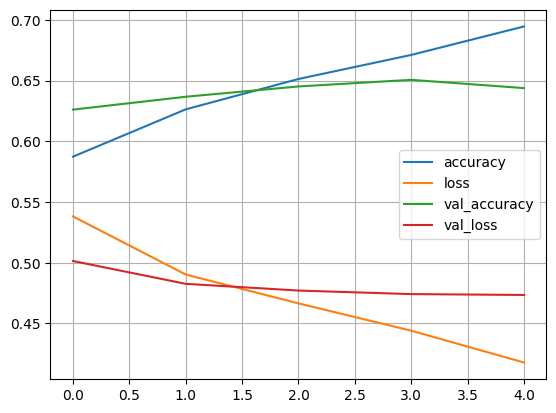

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion matrix:  col_0   -1    0     1
row_0                
-1     359  120   359
 0     145  863   244
 1     253  174  1152
              precision    recall  f1-score   support

          -1       0.47      0.43      0.45       838
           0       0.75      0.69      0.72      1252
           1       0.66      0.73      0.69      1579

    accuracy                           0.65      3669
   macro avg       0.63      0.62      0.62      3669
weighted avg       0.65      0.65      0.64      3669



In [58]:
model = models.load_model("my_keras_model.keras") # rollback to best model

loss, accuracy = model.evaluate(X_train_seq_trunc, y_train_oh, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test_seq_trunc, y_test_oh, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

#Prediction metrics
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test_seq_trunc, verbose=1)

y_pred_cat=np.argmax(y_pred,axis=1)-1
y_test_cat=np.argmax(y_test_oh,axis=1)-1
print("Confusion matrix: ",pd.crosstab(y_test_cat,y_pred_cat))

print(classification_report(y_test_cat,y_pred_cat))

### Fine tuning

In [59]:
from tensorflow.keras import initializers
model = models.Sequential()
model.add(layers.Input(shape=(MAX_LEN,)))
model.add(layers.Embedding(
    voc_len,
    EMBEDDING_SIZE,
    embeddings_initializer=initializers.Constant(embedding_matrix),
    trainable=True))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(DROP_RATE))
model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 100, 100)       │    10,870,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,123,411 (61.51 MB)

 Trainable params: 16,123,411 (61.51 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
checkpoint_cb = callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)


early_stopping_cb = callbacks.EarlyStopping(patience=PATIENCE,
                                                  restore_best_weights=True)
history = model.fit(X_train_seq_trunc, y_train_oh, epochs=NB_EPOCHS,
                    validation_data=(X_valid_seq_trunc, y_valid_oh),
                    callbacks=[checkpoint_cb, early_stopping_cb],batch_size=BATCH_SIZE)

Epoch 1/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 80s 149ms/step - accuracy: 0.5690 - loss: 0.5569 - val_accuracy: 0.6774 - val_loss: 0.4497
Epoch 2/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 84s 159ms/step - accuracy: 0.6932 - loss: 0.4261 - val_accuracy: 0.7401 - val_loss: 0.3824
Epoch 3/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 85s 161ms/step - accuracy: 0.7802 - loss: 0.3267 - val_accuracy: 0.7812 - val_loss: 0.3298
Epoch 4/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 85s 161ms/step - accuracy: 0.8484 - loss: 0.2429 - val_accuracy: 0.8125 - val_loss: 0.3065
Epoch 5/5
529/529 ━━━━━━━━━━━━━━━━━━━━ 83s 157ms/step - accuracy: 0.8888 - loss: 0.1812 - val_accuracy: 0.8217 - val_loss: 0.2987


Training Accuracy: 0.9715
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8199 - loss: 0.2889
Testing Accuracy:  0.8138


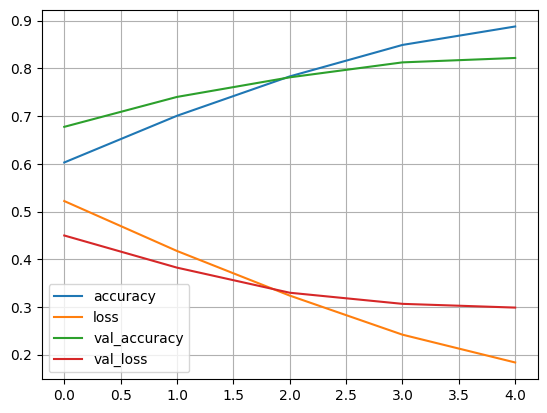

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion matrix:  col_0   -1     0     1
row_0                 
-1     501   109   228
 0      59  1101    92
 1     111    84  1384
              precision    recall  f1-score   support

          -1       0.75      0.60      0.66       838
           0       0.85      0.88      0.86      1252
           1       0.81      0.88      0.84      1579

    accuracy                           0.81      3669
   macro avg       0.80      0.78      0.79      3669
weighted avg       0.81      0.81      0.81      3669



In [61]:
model = models.load_model("my_keras_model.keras") # rollback to best model

loss, accuracy = model.evaluate(X_train_seq_trunc, y_train_oh, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test_seq_trunc, y_test_oh, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

#Prediction metrics
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test_seq_trunc, verbose=1)

y_pred_cat=np.argmax(y_pred,axis=1)-1
y_test_cat=np.argmax(y_test_oh,axis=1)-1
print("Confusion matrix: ",pd.crosstab(y_test_cat,y_pred_cat))

print(classification_report(y_test_cat,y_pred_cat))